#### 项目概要
- 此项目来源：github ***一根野猫猫***
- 此项目用途：复盘比赛时做的项目，***以备预推免的面试***
- 此项目的实现：大一时用MATLAB写的，***这里用Python复现一遍***
- 该项目的代码从第一问开始，我会将详尽的分析和注释写下，以记录我解决问题的详细思路。



#### 研究了什么问题
生鲜商超自动定价和补货的问题，也就是通过供求关系来进行利益最大化的决策问题。如果从日常生活来说的话，可以理解为超市里的商品如何定价和补货的问题。
- 附件一是各种单品的分类信息，花叶类，瓜果类，茄子类里面分别有什么单品
- 附件二是交易的时间流水信息，有几十万条
- 附件三是每日商品的进货价格流水
- 附件四是各种单品的损耗率


#### 问题二解析
1. 数据到2023六月底，分析未来一周的日补货总量和定价策略，使得收益最大化。
2. 这是一个优化模型，优化的目标是收益，自变量是补货总量和定价
3. 自变量限制条件，补货总量不能低于最低销量，不能高于最高销量，定价不能低于最低定价，不能高于最高定价。
4. 销量可以看成定价和进货价的函数，通过多项式拟合来表示（一般是个反比例函数）
5. 进货成本未知，通过随机森林回归，预测未来七天的批发价格
6. 通过批发价格，损耗率，售价，售价计算出的销量来表示收益，并通过模拟退火算法求解，得出定价和补货总量（补货总量即销量），以及最后优化出的最佳收益。

#### 项目结构
- 代码存放：根目录
- 数据存放：根目录下的data/

#### 数据处理分析
- 大致方向：（补货，定价）->Max(收益)
- 建模方向：（批发价格，损耗率，售价，销量）->收益    其中(批发价格，售价)->销量   即 销量 = f(批发价格, 售价)
- 因此，在此问中，四张表格的数据均需用到。
接下来将进行数据预处理，以合并4张表格

In [ ]:
# 读取四张表
import pandas as pd
data1=pd.read_excel('附件1.xlsx')
data2=pd.read_excel('附件2.xlsx')
data3=pd.read_excel('附件3.xlsx')
data4=pd.read_excel('附件4.xlsx',sheet_name='Sheet1')

In [10]:
# 融合四张表
# 不同单品不同日期的数据不同，所以要按照这个合并表格
merged_data = pd.merge(data1, data2, left_on="单品编码", right_on="单品编码", how="right")
merged_data['合并主键']=pd.to_datetime(merged_data['销售日期']).map(str)+'-'+merged_data['单品编码'].map(str)
data3['合并主键']=data3['销售日期'].map(str)+'-'+data3['单品编码'].map(str)
#基于单品编码列合并两个数据集
merged_data=pd.merge(merged_data, data3, left_on="合并主键", right_on="合并主键", how="left")
merged_data.columns
# 按照合并主键合并后，其它相同的列会用_x _y区分，接下来合并表4，并消除这些
merged_data=pd.merge(merged_data, data4, left_on="单品编码_x", right_on="单品编码", how="left")
del merged_data['单品名称_y']
del merged_data['单品编码']
del merged_data['销售日期_y']
del merged_data['单品编码_y']
merged_data.columns=['单品编码', '单品名称', '分类编码', '分类名称', '销售日期', '扫码销售时间', '销量(千克)',
       '销售单价(元/千克)', '销售类型', '是否打折销售', '合并主键', '批发价格(元/千克)', '损耗率(%)']
del merged_data['合并主键']
merged_data


,单品编码,单品名称,分类编码,分类名称,销售日期,扫码销售时间,销量(千克),销售单价(元/千克),销售类型,是否打折销售,批发价格(元/千克),损耗率(%)
0,102900005117056,泡泡椒(精品),1011010504,辣椒类,2020-07-01,09:15:07.924,0.396,7.6,销售,否,4.32,7.08
1,102900005115960,大白菜,1011010101,花叶类,2020-07-01,09:17:27.295,0.849,3.2,销售,否,2.10,22.27
2,102900005117056,泡泡椒(精品),1011010504,辣椒类,2020-07-01,09:17:33.905,0.409,7.6,销售,否,4.32,7.08
3,102900005115823,上海青,1011010101,花叶类,2020-07-01,09:19:45.450,0.421,10.0,销售,否,7.03,14.43
4,102900005115908,菜心,1011010101,花叶类,2020-07-01,09:20:23.686,0.539,8.0,销售,否,4.60,13.70
...,...,...,...,...,...,...,...,...,...,...,...,...
878498,102900005115250,西峡花菇(1),1011010801,食用菌,2023-06-30,21:35:13.264,0.284,24.0,销售,否,15.60,10.80
878499,102900011022764,长线茄,1011010501,茄类,2023-06-30,21:35:14.358,0.669,12.0,销售,否,7.00,6.90
878500,102900005115250,西峡花菇(1),1011010801,食用菌,2023-06-30,21:35:20.264,0.125,24.0,销售,否,15.60,10.80
878501,102900011016701,芜湖青椒(1),1011010504,辣椒类,2023-06-30,21:35:21.509,0.252,5.2,销售,否,3.63,5.70


接下来保存merged_data，将其保存为csv格式，因为相对于xlsx格式，csv加载的更快，适合存储大数据。

In [ ]:
import os
save_path = os.path.join("data", "merged_data_1234.csv")
# 确保 data 文件夹存在
os.makedirs("data", exist_ok=True)
# 保存文件
merged_data.to_csv(save_path, index=None, encoding="gbk")
# 至此数据预处理完毕

接下来，就是基于数学模型，使用优化算法进行求解了，先读取数据。

In [3]:
import pandas as pd
import os
# 读取数据
load_path = os.path.join("data", "merged_data_1234.csv")
merged_data = pd.read_csv(load_path, encoding="gbk")
merged_data


,单品编码,单品名称,分类编码,分类名称,销售日期,扫码销售时间,销量(千克),销售单价(元/千克),销售类型,是否打折销售,批发价格(元/千克),损耗率(%)
0,102900005117056,泡泡椒(精品),1011010504,辣椒类,2020-07-01,09:15:07.924,0.396,7.6,销售,否,4.32,7.08
1,102900005115960,大白菜,1011010101,花叶类,2020-07-01,09:17:27.295,0.849,3.2,销售,否,2.10,22.27
2,102900005117056,泡泡椒(精品),1011010504,辣椒类,2020-07-01,09:17:33.905,0.409,7.6,销售,否,4.32,7.08
3,102900005115823,上海青,1011010101,花叶类,2020-07-01,09:19:45.450,0.421,10.0,销售,否,7.03,14.43
4,102900005115908,菜心,1011010101,花叶类,2020-07-01,09:20:23.686,0.539,8.0,销售,否,4.60,13.70
...,...,...,...,...,...,...,...,...,...,...,...,...
878498,102900005115250,西峡花菇(1),1011010801,食用菌,2023-06-30,21:35:13.264,0.284,24.0,销售,否,15.60,10.80
878499,102900011022764,长线茄,1011010501,茄类,2023-06-30,21:35:14.358,0.669,12.0,销售,否,7.00,6.90
878500,102900005115250,西峡花菇(1),1011010801,食用菌,2023-06-30,21:35:20.264,0.125,24.0,销售,否,15.60,10.80
878501,102900011016701,芜湖青椒(1),1011010504,辣椒类,2023-06-30,21:35:21.509,0.252,5.2,销售,否,3.63,5.70


- 由于有六大品类，每个品类中销量与进货价格和售价的关系均不同，所以要分开讨论计算。
- 于是我们采用循环，每个循环都对其中一个品类进行求解。
- 首先导入一些包，以及定义一些函数（用于表示真实值和预测值之间的误差）

In [4]:
# 此处所引入的包大部分为下文机器学习算法
import pandas as pd
from numpy import *
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import numpy as np
import xgboost as xgb



import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,r2_score

import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
def mape(actual, pred):   # 用于计算预测值和真实值之间的误差
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error #均方误差
from sklearn.metrics import mean_absolute_error #平方绝对误差

def score(y_true, y_pre):  # 用于评估随机森林预测
    # MSE
    print("MSE :")
    print(metrics.mean_squared_error(y_true, y_pre)) 
    # RMSE
    print("RMSE :")
    print(np.sqrt(metrics.mean_squared_error(y_true, y_pre))) 
    # MAE
    print("MAE :")
    print(metrics.mean_absolute_error(y_true, y_pre)) 
    # R2
    print("R2 :")
    print(r2_score(y_true,y_pre)) 
import numpy as np
from deap import base, creator, tools, algorithms
import xgboost as xgb


#### 建模分析
- 损耗率表示进货量和实际卖出之间的关系，销售量=(1-损耗率)*进货量
- 收益 = 销售额 - 进货成本 = 销售额 - 批发价格 * 进货量 = 销售额 - 批发价格 * （销售量 / (1-损耗率)）
- 为保证精确度，这里采用**XGBOOST回归**来计算销量


分类名称辣椒类

XGBOOST回归:
测试集平均绝对百分比误差:0.157
测试集r2_score 0.8746837042373012
MSE :
1.5826305186818947
RMSE :
1.2580264379900348
MAE :
0.9416469768994827
R2 :
0.643806770211883


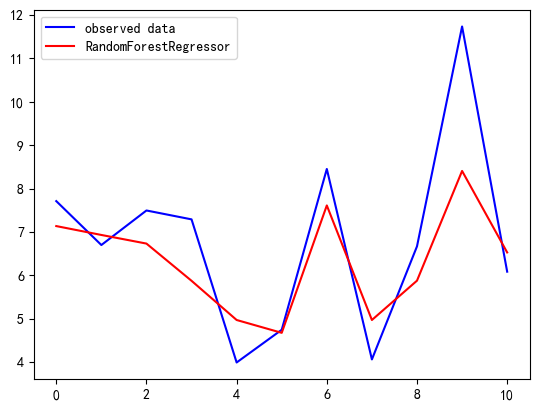

损耗率为7.745065

catagory辣椒类day1:


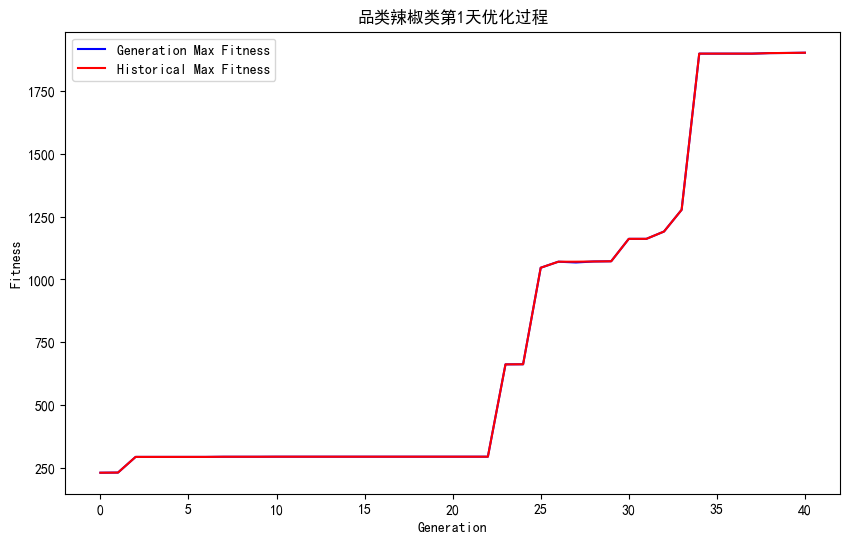


catagory辣椒类day2:


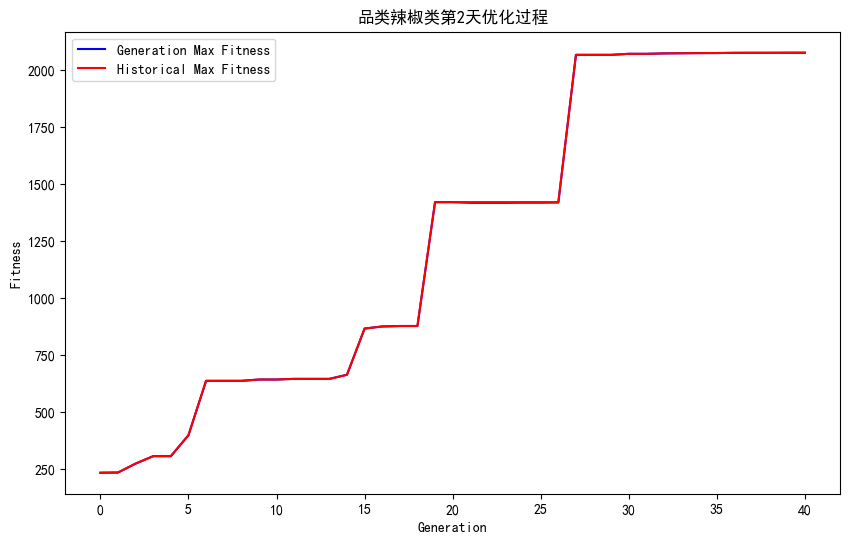


catagory辣椒类day3:


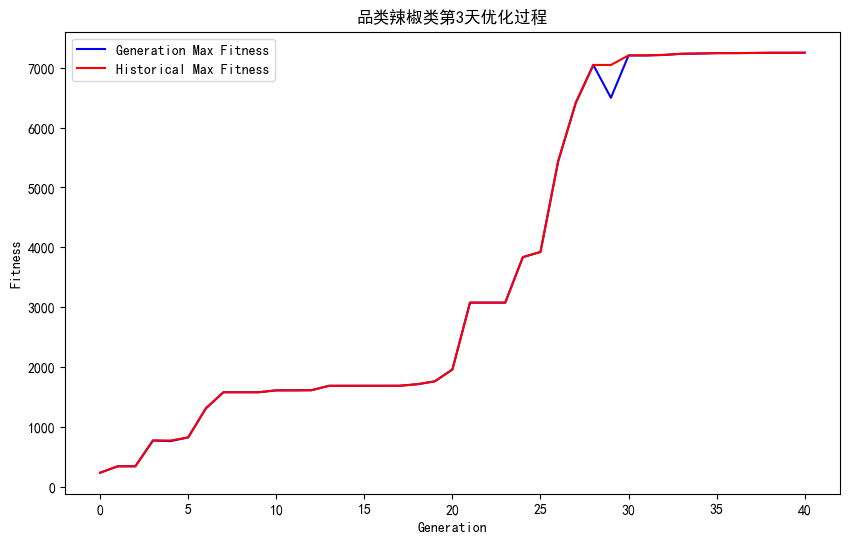


catagory辣椒类day4:


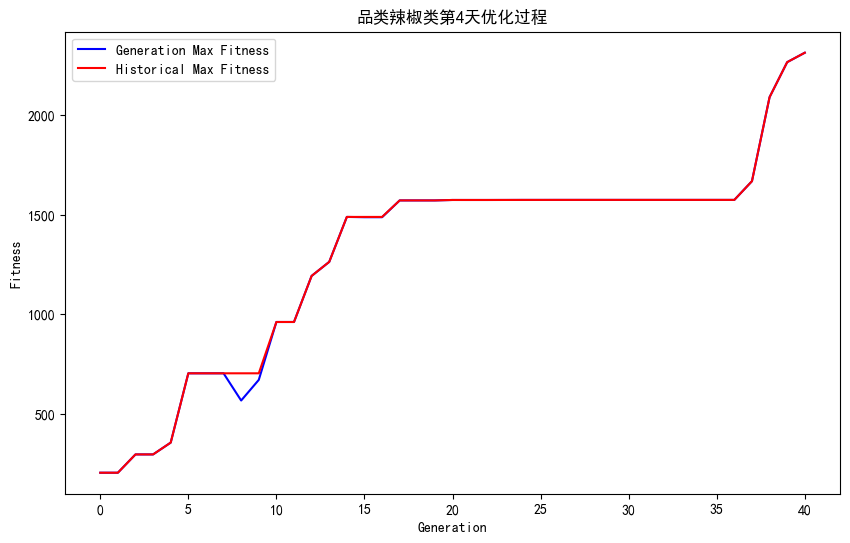

差异警告: 适应度(1494.7344658504257) vs 利润(1494.7225412370449)

catagory辣椒类day5:


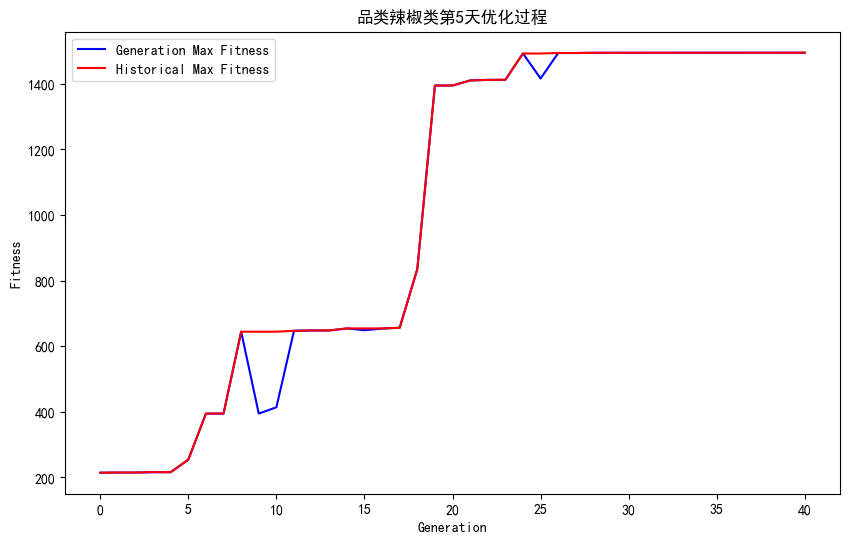


catagory辣椒类day6:


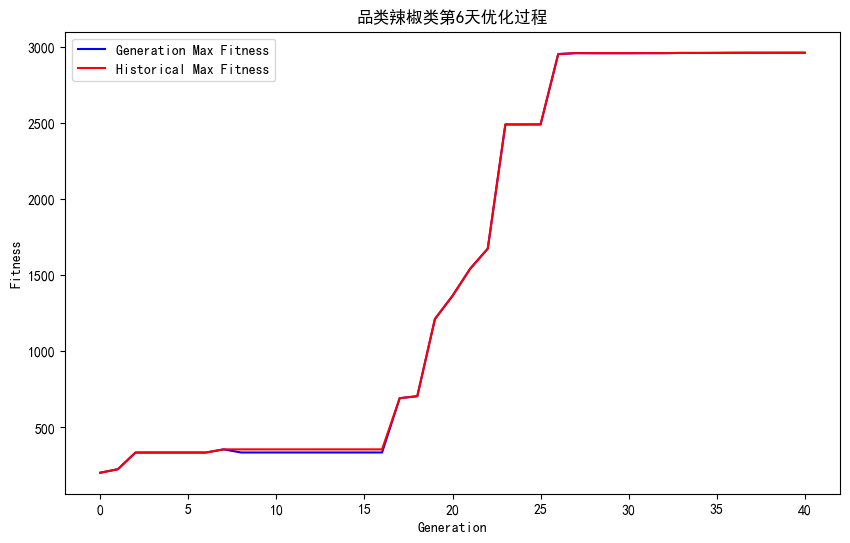

差异警告: 适应度(2420.58919219854) vs 利润(1952.5620563739365)

catagory辣椒类day7:


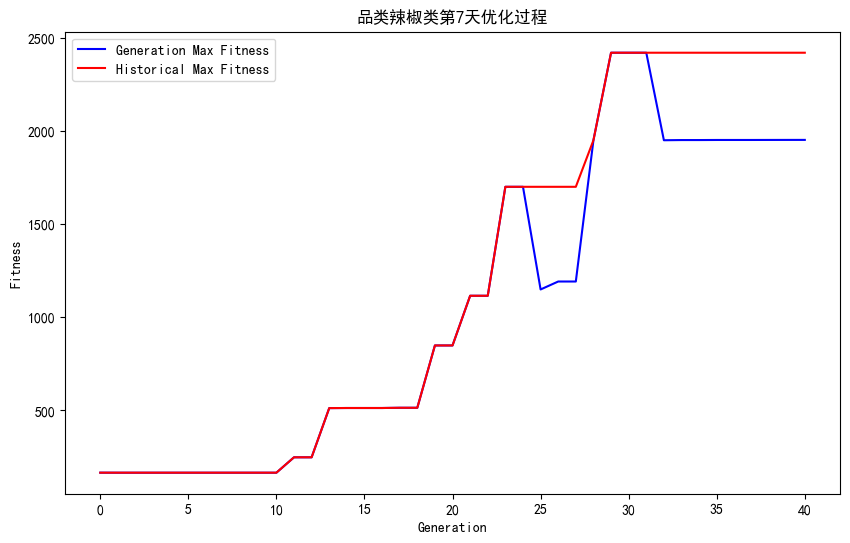


最终优化结果:
Optimal Selling Prices: [13.783378180945137, 13.881813870920677, 22.730731803924805, 16.805423072954614, 11.75101412242675, 13.8816631226439, 13.748759921378298]
Sales Volumes: [253.78894, 260.63843, 415.0473, 201.2252, 225.24051, 348.8381, 239.45897]
Daily Profits: [1901.7983625000522, 2076.862355313988, 7250.641616905759, 2313.4083698087406, 1494.7225412370449, 2960.726171375979, 1952.5620563739365]
Total Profit: 19950.7214735155
品类辣椒类优化完成，结果已保存

分类名称花叶类

XGBOOST回归:
测试集平均绝对百分比误差:0.154
测试集r2_score 0.8839201413375827
MSE :
0.10664106058563676
RMSE :
0.32655942887265826
MAE :
0.24744655125793705
R2 :
0.7886536139509307


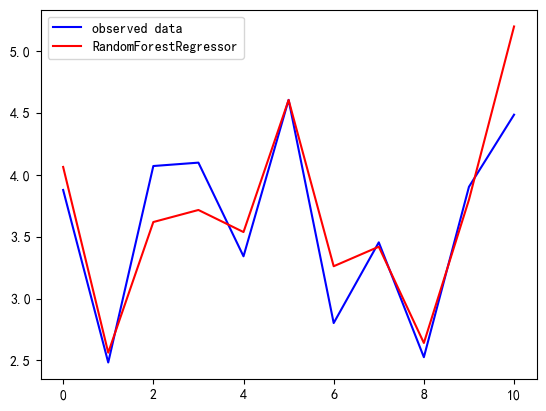

损耗率为12.636640

catagory花叶类day1:


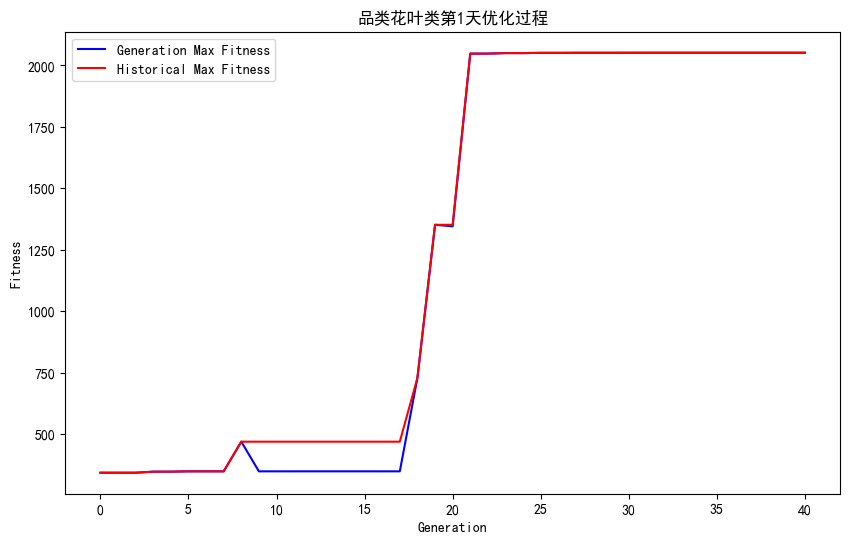


catagory花叶类day2:


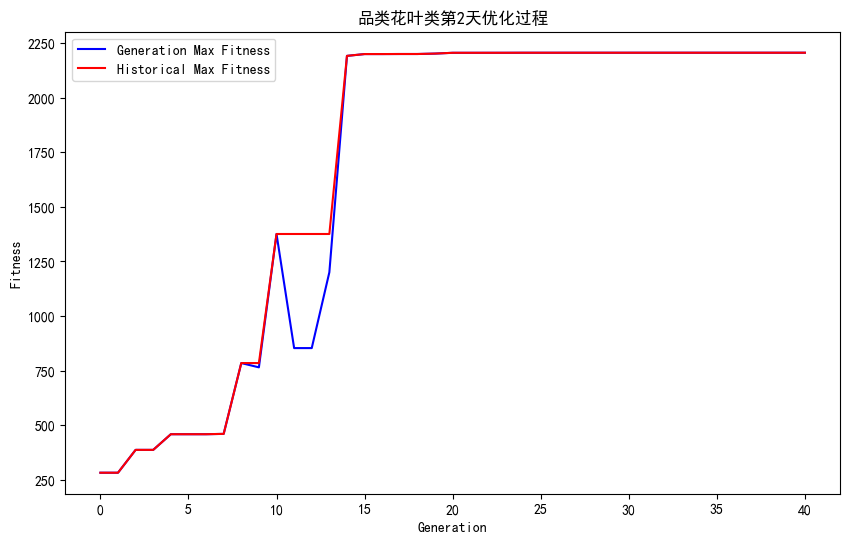

差异警告: 适应度(1341.5386276246043) vs 利润(1341.5347079012693)

catagory花叶类day3:


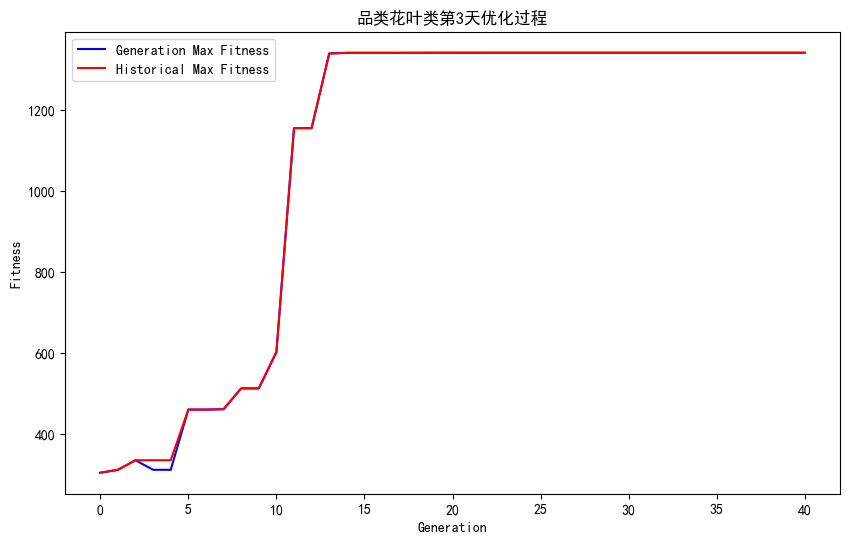

差异警告: 适应度(2060.9718827892357) vs 利润(2060.8034373471774)

catagory花叶类day4:


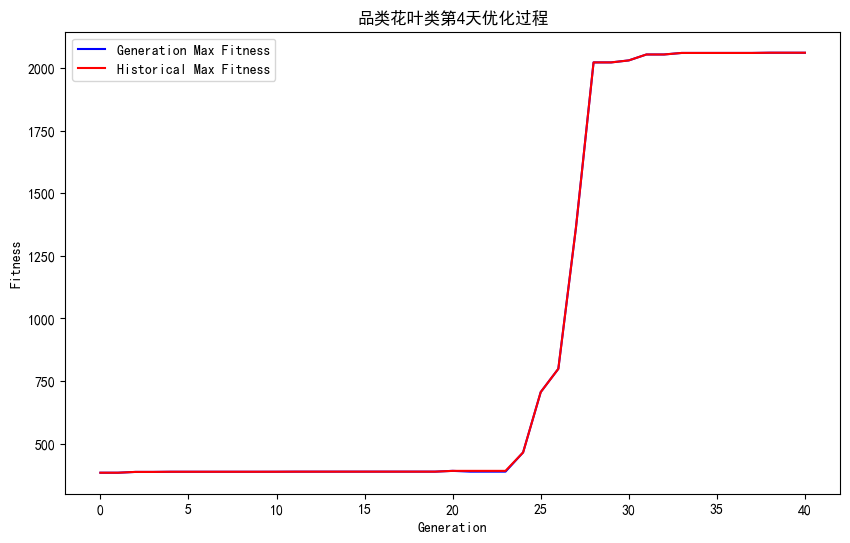

差异警告: 适应度(1286.6245151405367) vs 利润(1286.6145777925356)

catagory花叶类day5:


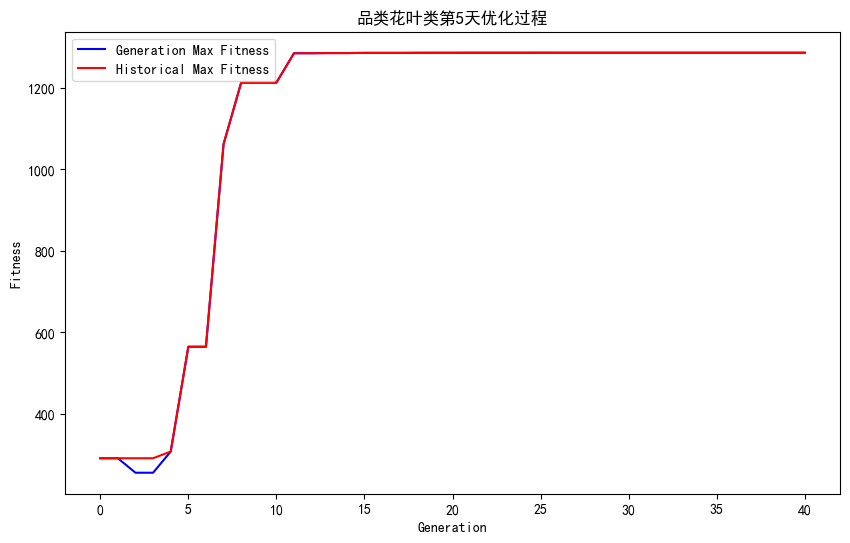


catagory花叶类day6:


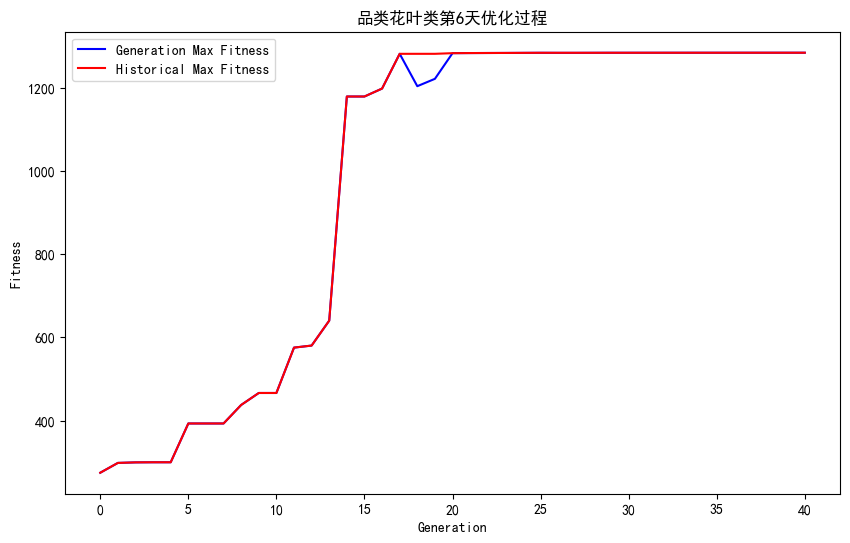

差异警告: 适应度(2214.1270620950168) vs 利润(2214.109925103271)

catagory花叶类day7:


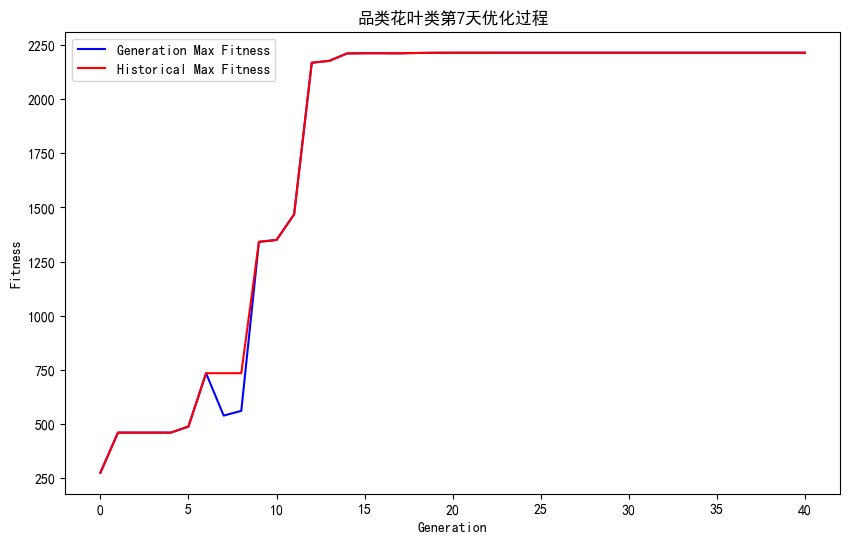


最终优化结果:
Optimal Selling Prices: [8.337755115777819, 8.358346875165989, 7.452042777582882, 8.357945501263366, 7.4520269316735845, 7.4486021883880005, 8.357383538543486]
Sales Volumes: [472.40793, 479.99274, 391.2854, 475.35794, 379.239, 388.84552, 483.30237]
Daily Profits: [2051.5089097165956, 2205.8613828336393, 1341.5347079012693, 2060.8034373471774, 1286.6145777925356, 1283.6566500576757, 2214.109925103271]
Total Profit: 12444.089590752163
品类花叶类优化完成，结果已保存

分类名称水生根茎类

XGBOOST回归:
测试集平均绝对百分比误差:0.357
测试集r2_score 0.9161908658532696
MSE :
0.6251492755276378
RMSE :
0.7906638195387707
MAE :
0.5165658409599198
R2 :
0.9124379998265428


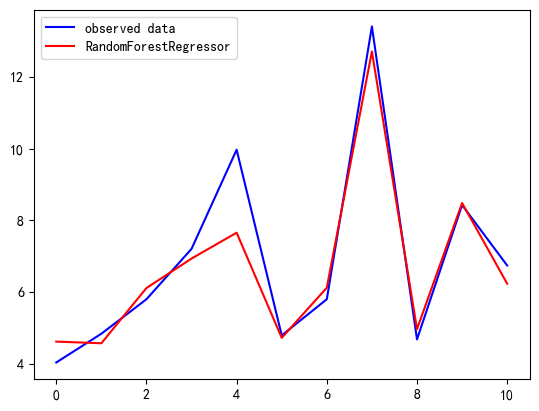

损耗率为9.995515

catagory水生根茎类day1:


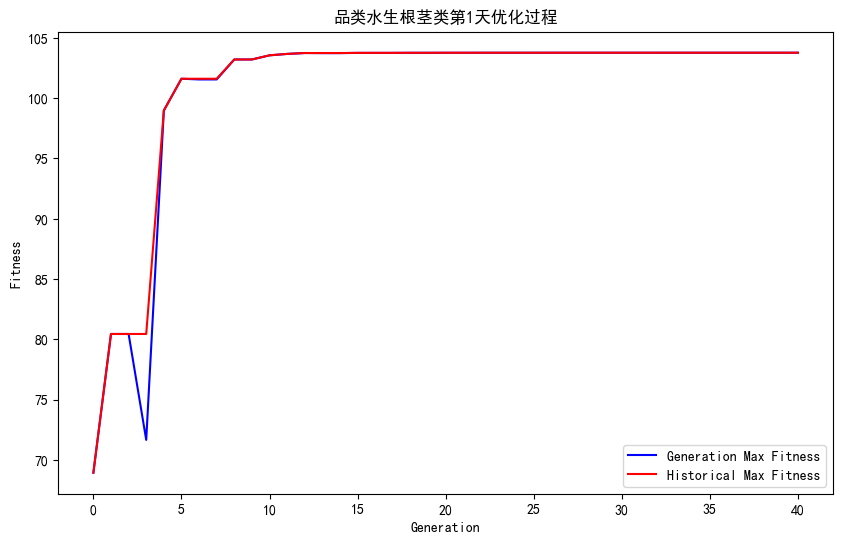


catagory水生根茎类day2:


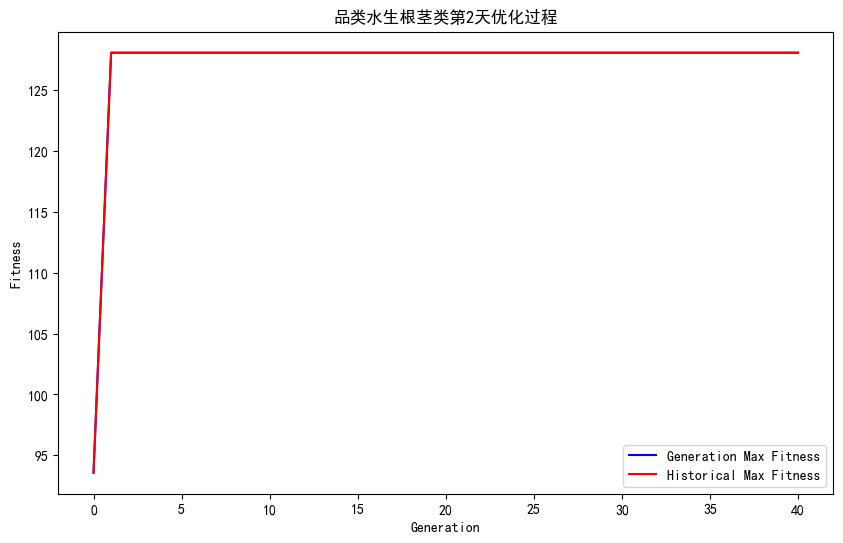

差异警告: 适应度(454.4732876734298) vs 利润(448.22397246418245)

catagory水生根茎类day3:


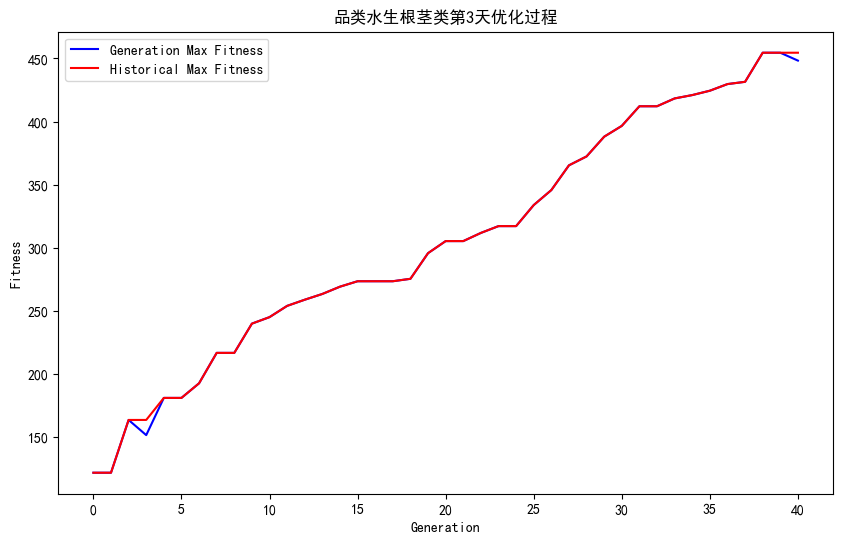


catagory水生根茎类day4:


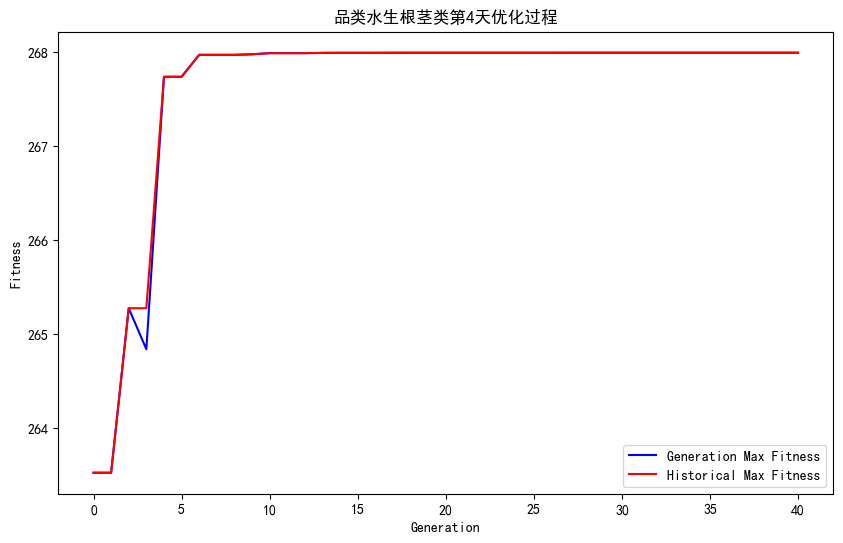

差异警告: 适应度(239.58436997732076) vs 利润(239.58336201747557)

catagory水生根茎类day5:


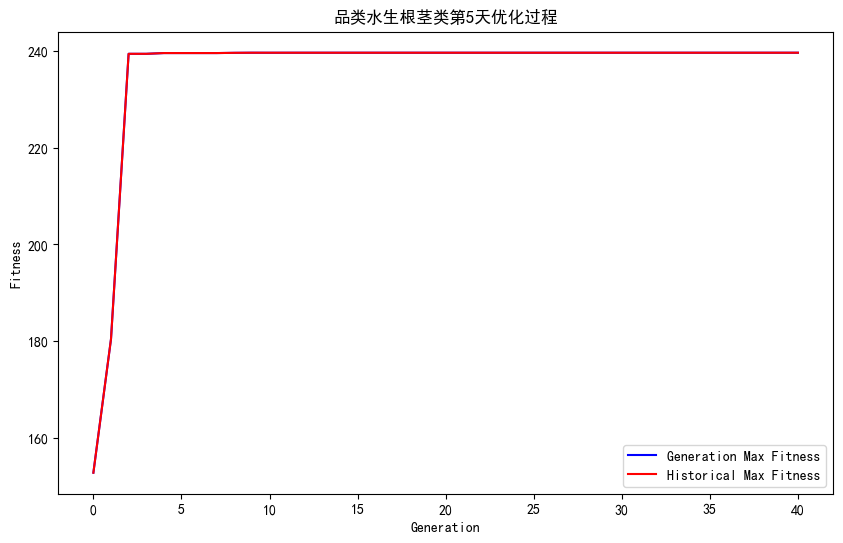


catagory水生根茎类day6:


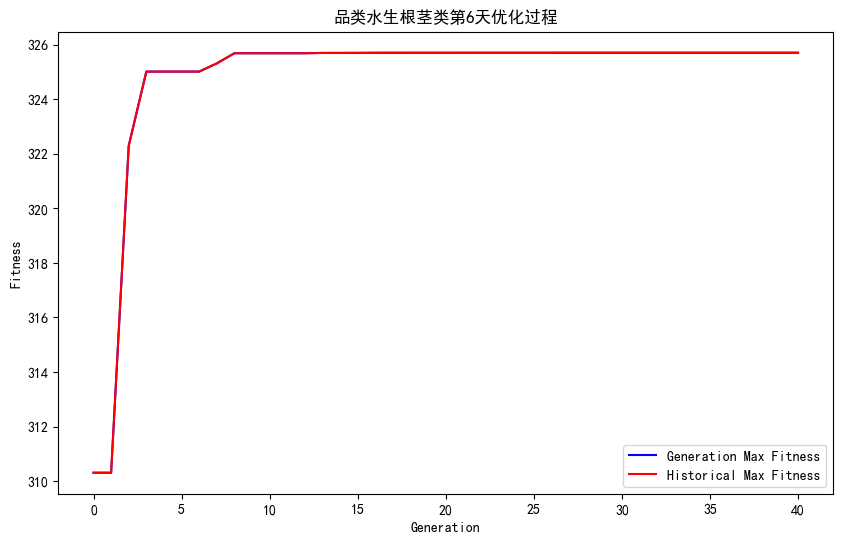


catagory水生根茎类day7:


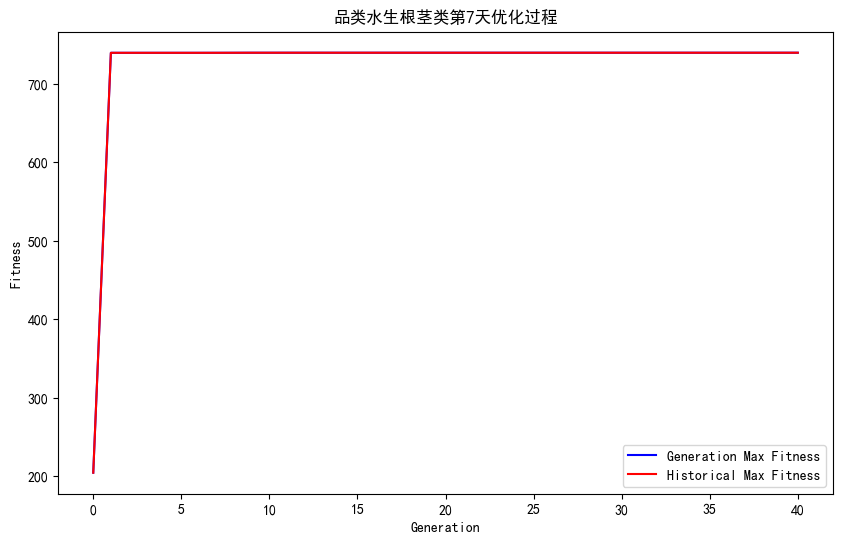


最终优化结果:
Optimal Selling Prices: [19.42981521629391, 14.173859756710444, 38.64890520304931, 12.836318546336965, 14.17497982728064, 12.83621486804194, 13.15454528737456]
Sales Volumes: [15.645021, 58.373245, 16.596357, 103.19119, 69.3842, 118.265625, 174.39058]
Daily Profits: [103.77031576894123, 128.10549251853763, 448.22397246418245, 267.9924406345792, 239.58336201747557, 325.7079878814161, 739.4925759953553]
Total Profit: 2252.8761472804877
品类水生根茎类优化完成，结果已保存

分类名称食用菌

XGBOOST回归:
测试集平均绝对百分比误差:0.177
测试集r2_score 0.9290973513877004
MSE :
0.44430835885647063
RMSE :
0.6665645946616656
MAE :
0.574614653228181
R2 :
0.8518795038770092


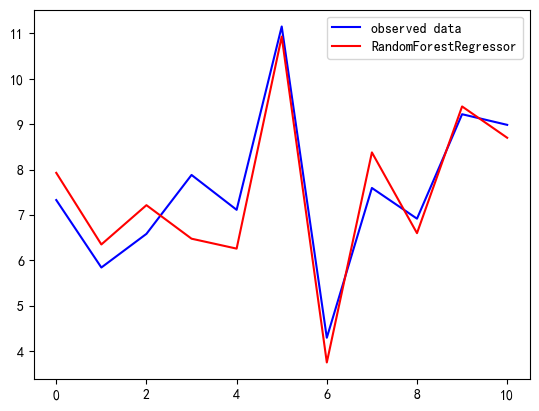

损耗率为8.758815

catagory食用菌day1:


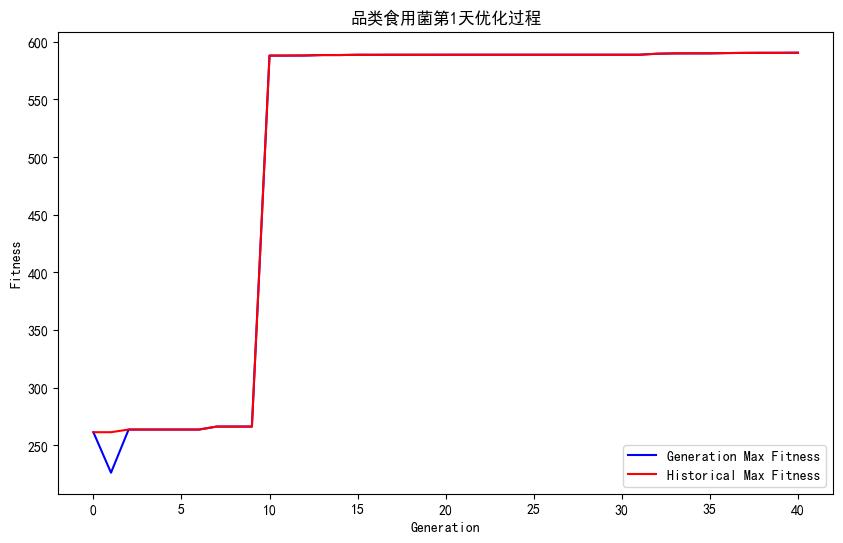


catagory食用菌day2:


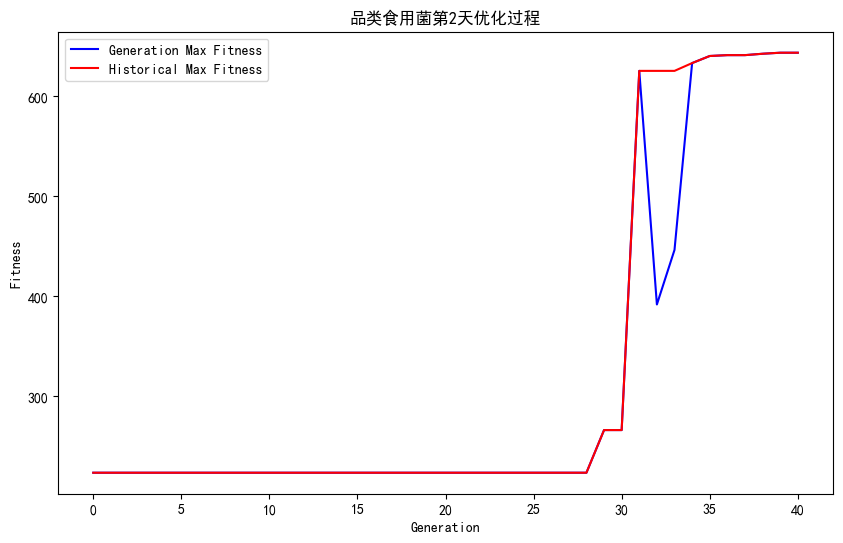

差异警告: 适应度(592.7702657030062) vs 利润(438.0870601874806)

catagory食用菌day3:


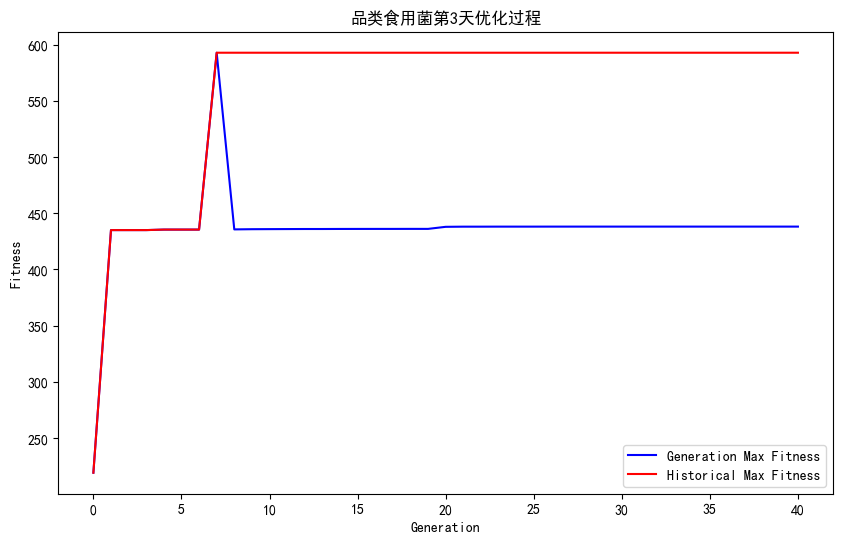


catagory食用菌day4:


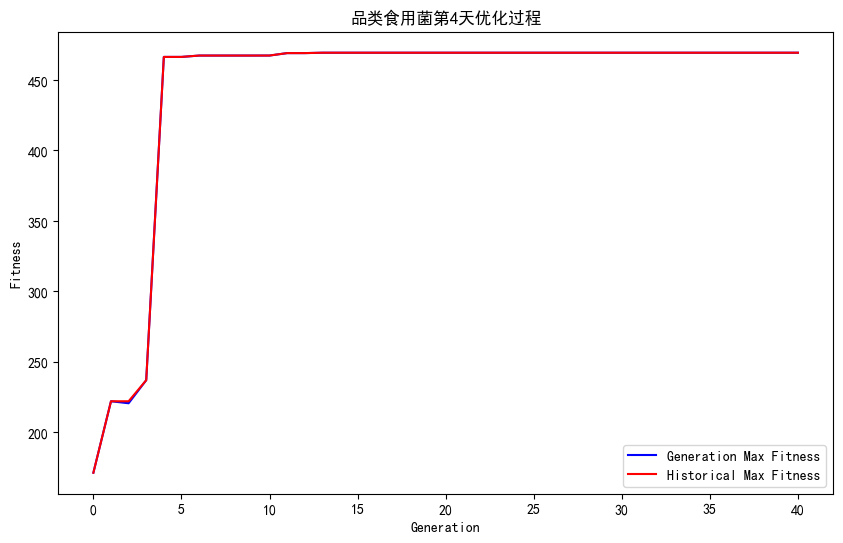


catagory食用菌day5:


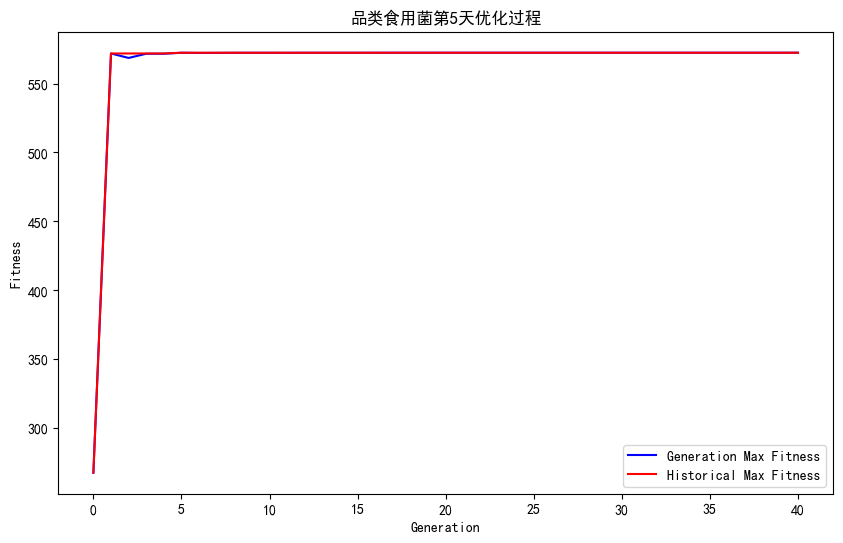


catagory食用菌day6:


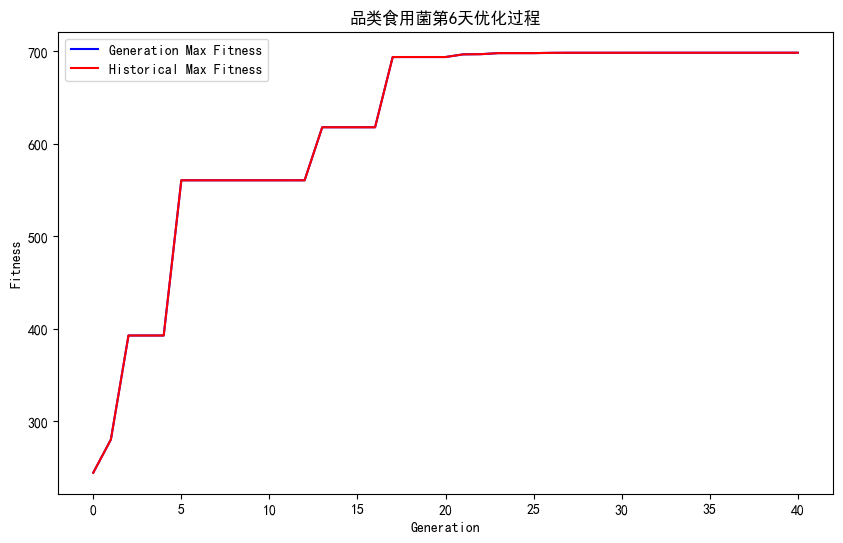


catagory食用菌day7:


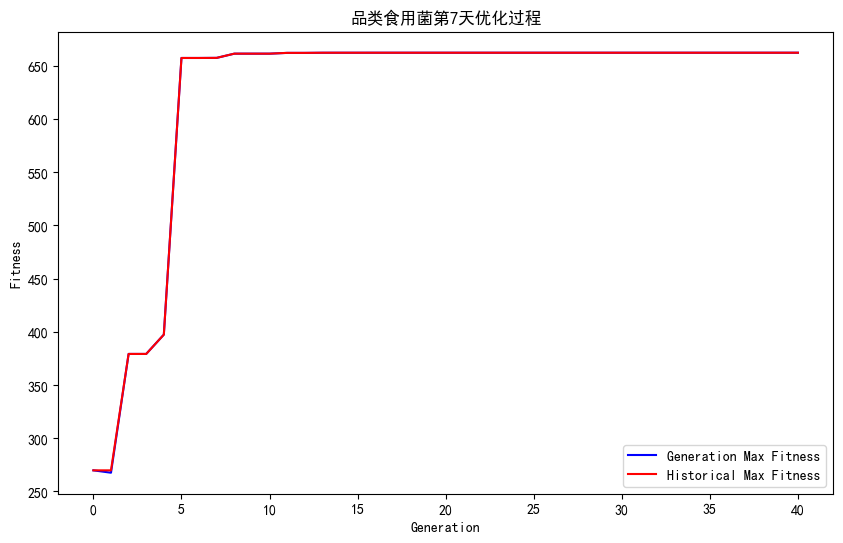


最终优化结果:
Optimal Selling Prices: [12.438861371950138, 16.79034989422056, 12.439340399454169, 12.439338356657924, 11.931110858087482, 12.80045691790713, 11.223487062999974]
Sales Volumes: [183.39087, 92.3157, 187.2948, 180.07312, 173.58589, 149.75719, 188.9714]
Daily Profits: [590.4648331236172, 643.4204959508758, 438.0870601874806, 469.3918650993867, 572.5377105574948, 698.347773345221, 662.1246534305085]
Total Profit: 4074.374391694584
品类食用菌优化完成，结果已保存

分类名称花菜类

XGBOOST回归:
测试集平均绝对百分比误差:0.249
测试集r2_score 0.8913781184471081
MSE :
1.0687003205112993
RMSE :
1.0337796286014245
MAE :
0.5055311318772434
R2 :
0.8431230253648453


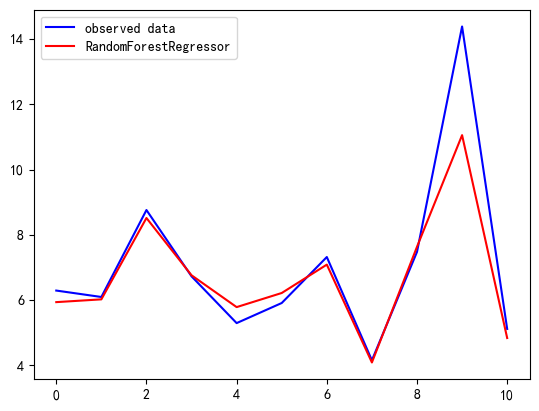

损耗率为10.482727

catagory花菜类day1:


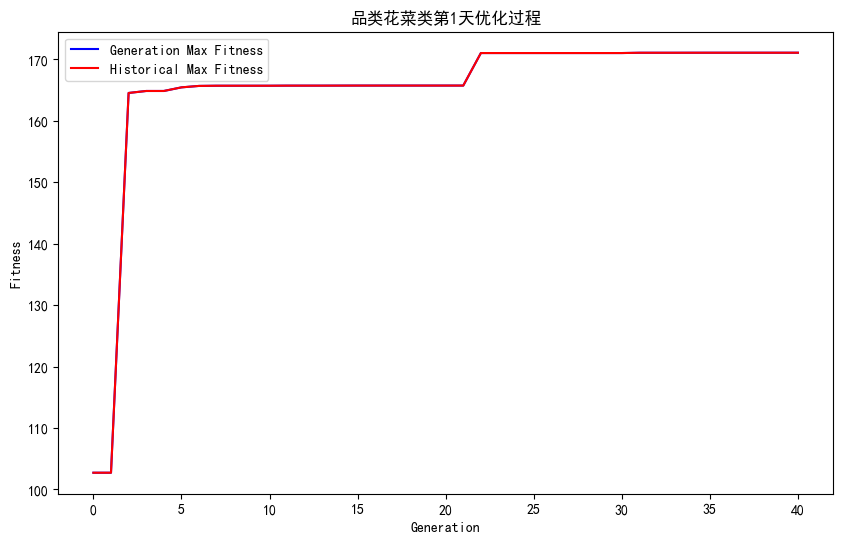


catagory花菜类day2:


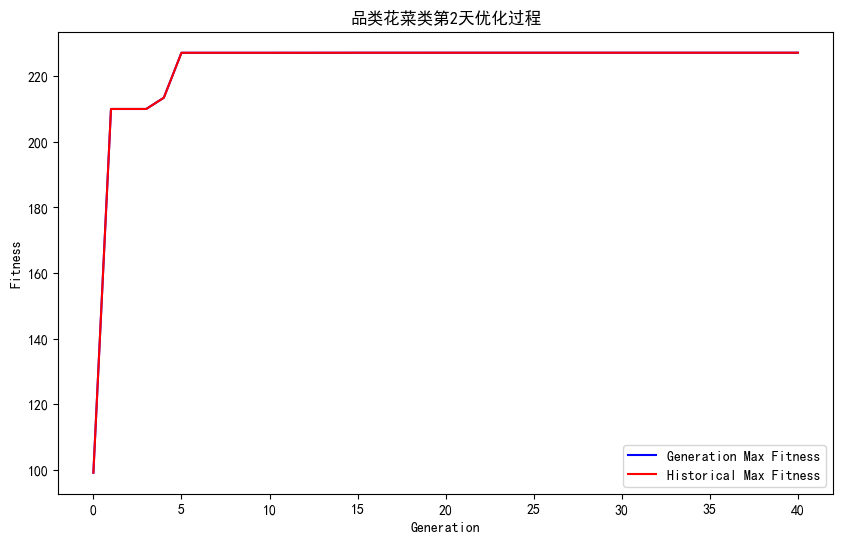


catagory花菜类day3:


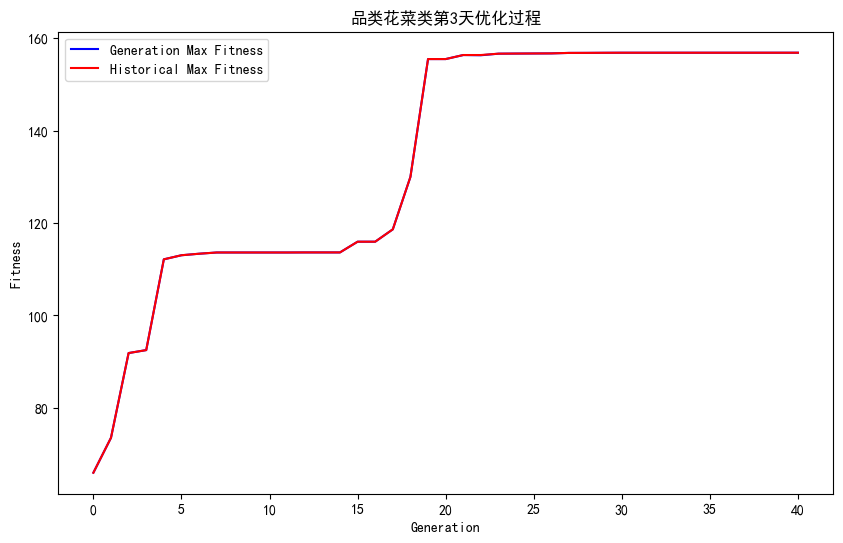


catagory花菜类day4:


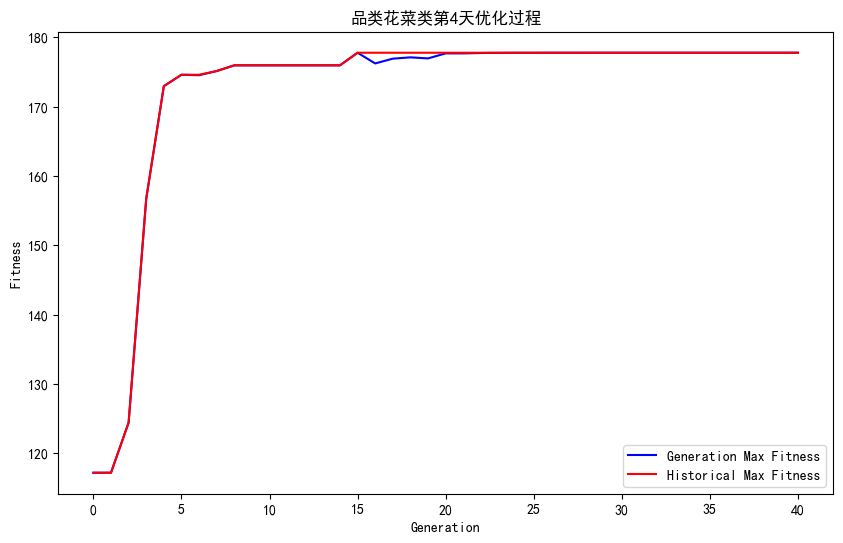


catagory花菜类day5:


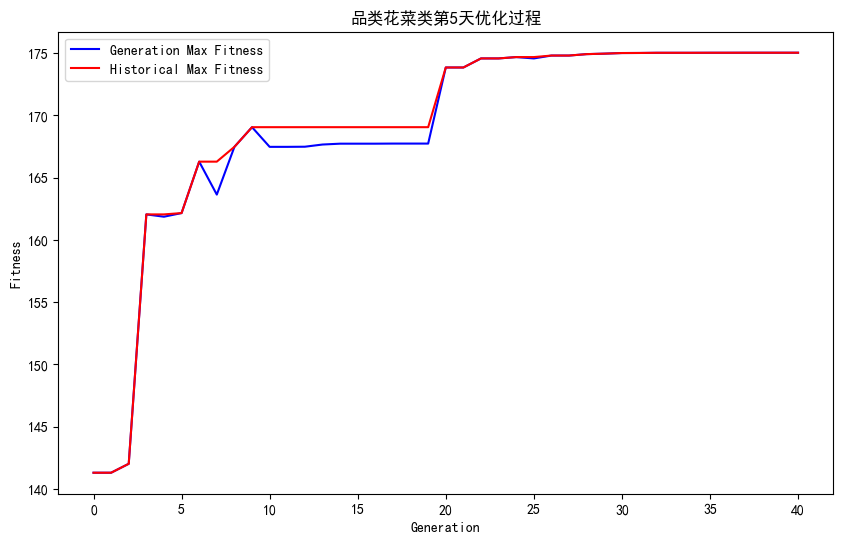


catagory花菜类day6:


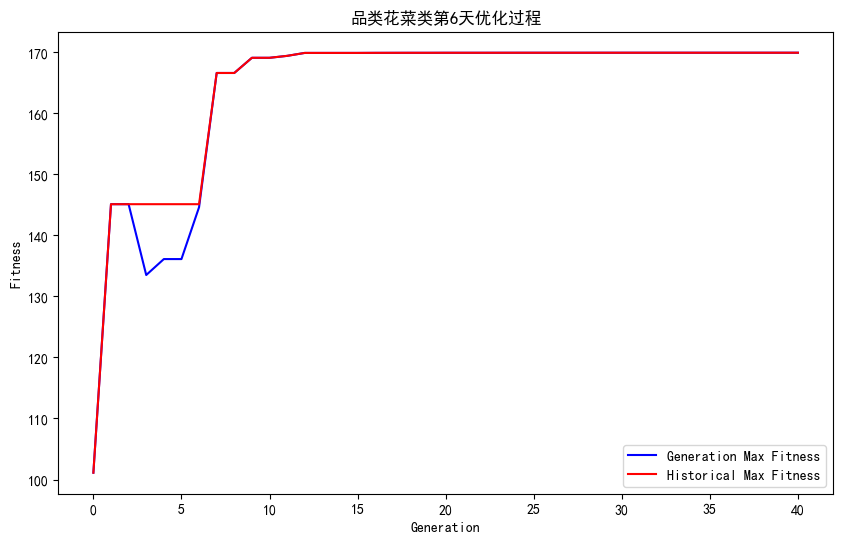


catagory花菜类day7:


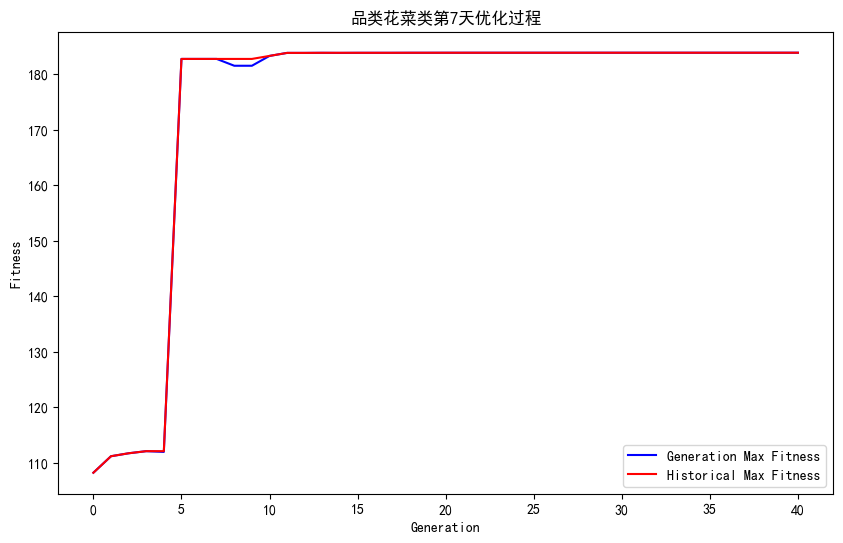


最终优化结果:
Optimal Selling Prices: [13.56665871576373, 12.527149675721287, 12.527272160257183, 13.566666120720521, 13.558671301269298, 11.660047900351465, 11.663998962173896]
Sales Volumes: [38.0079, 61.865025, 34.858486, 32.621086, 33.765976, 40.954323, 44.29766]
Daily Profits: [171.07920310452351, 227.18927318435556, 156.85952342539622, 177.7632033178649, 175.0256277172009, 169.95355413934737, 183.86817812553295]
Total Profit: 1261.7385630142214
品类花菜类优化完成，结果已保存

分类名称茄类

XGBOOST回归:
测试集平均绝对百分比误差:0.228
测试集r2_score 0.8634210395570558
MSE :
0.4007374098439605
RMSE :
0.6330382372684611
MAE :
0.5053057880459005
R2 :
0.905403942175977


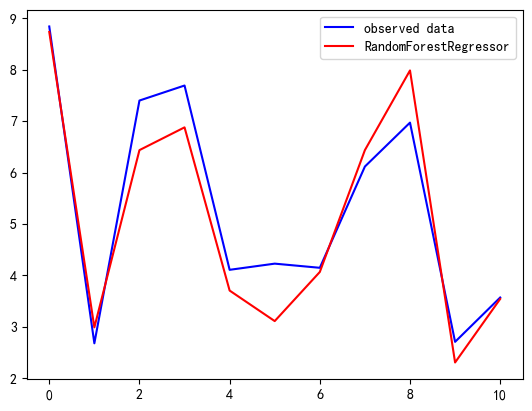

损耗率为6.367586

catagory茄类day1:


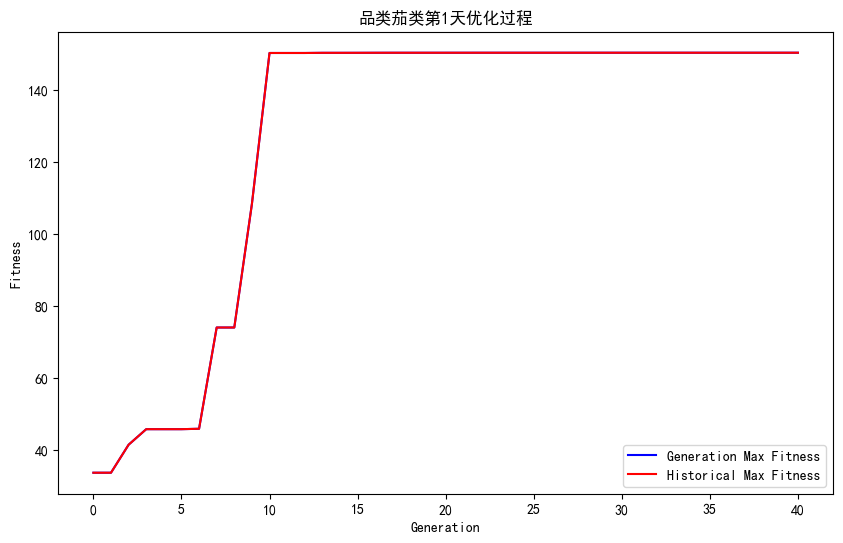

差异警告: 适应度(130.39698813290227) vs 利润(129.83693140966727)

catagory茄类day2:


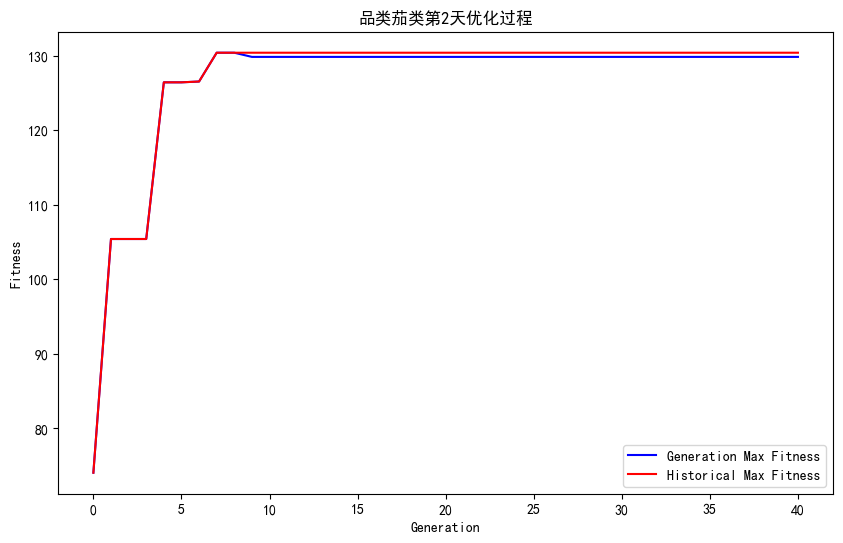


catagory茄类day3:


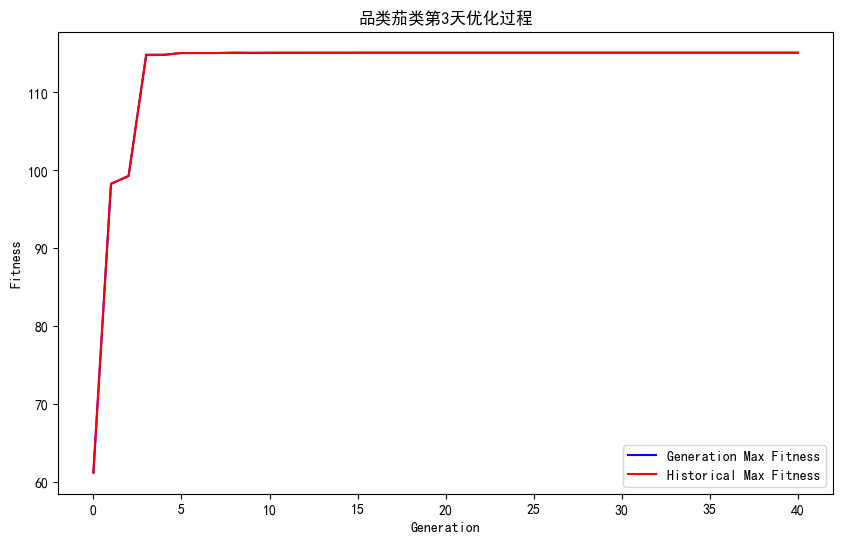

差异警告: 适应度(194.95559865449377) vs 利润(194.95379227801533)

catagory茄类day4:


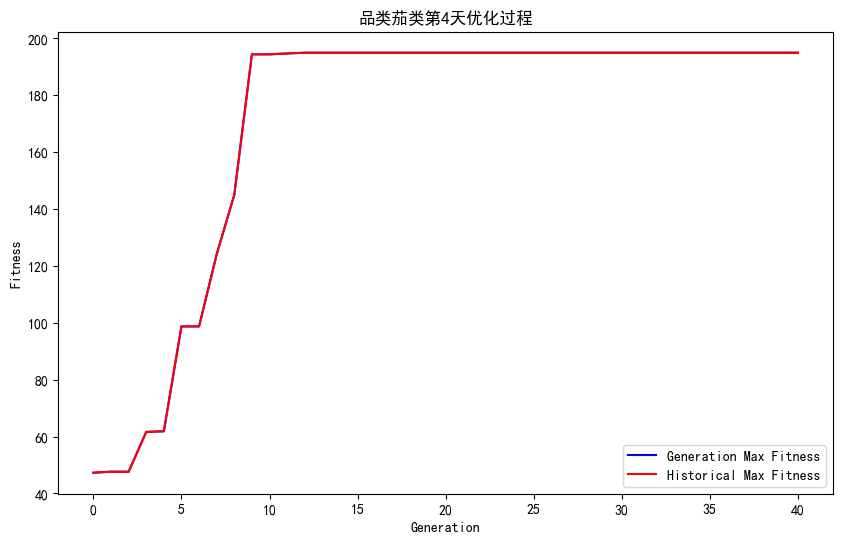


catagory茄类day5:


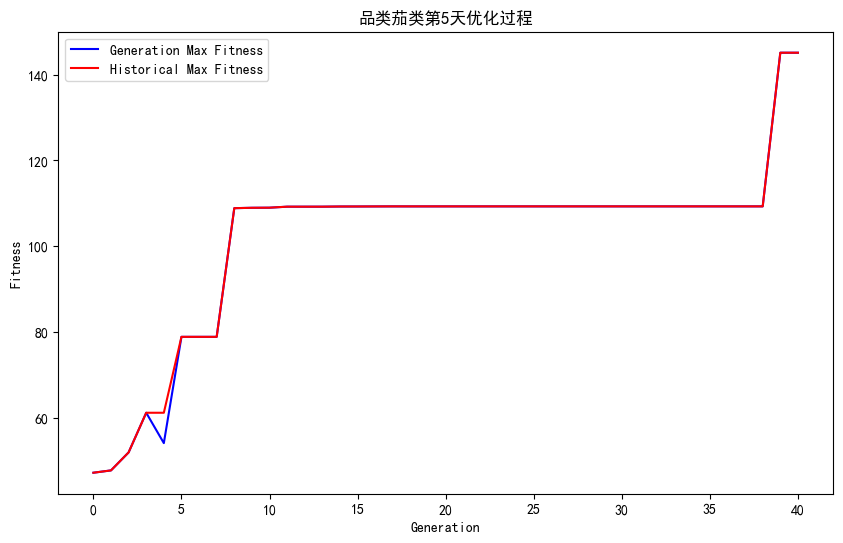


catagory茄类day6:


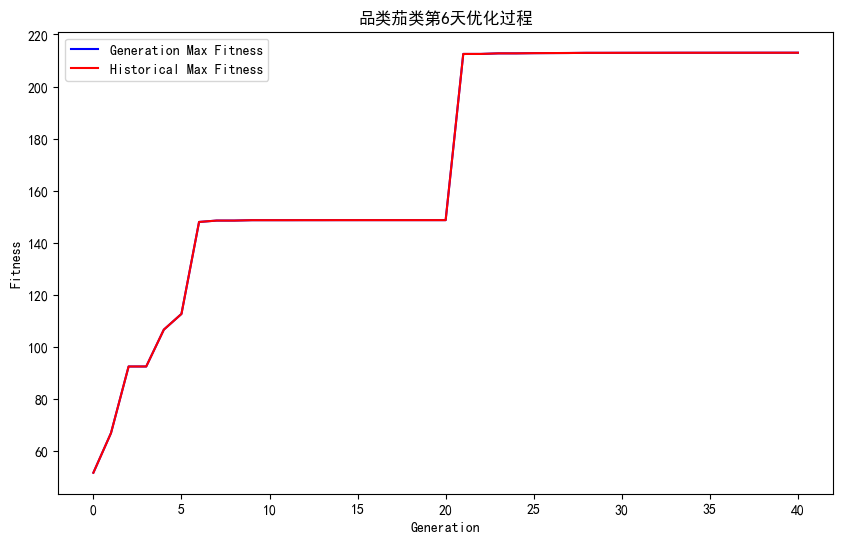


catagory茄类day7:


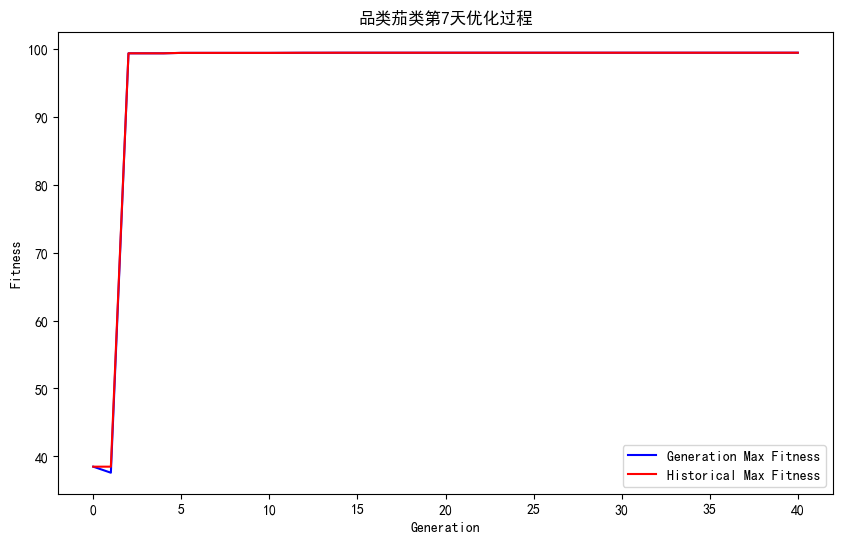


最终优化结果:
Optimal Selling Prices: [7.93705550572471, 7.48184158938925, 7.138858034712861, 7.93770052477927, 7.89154249814385, 7.9369197797573925, 7.138619290305032]
Sales Volumes: [46.98733, 52.796833, 52.58941, 58.70272, 44.30384, 63.903603, 45.92708]
Daily Profits: [150.2714719551838, 129.83693140966727, 115.0943328079199, 194.95379227801533, 145.12469551478307, 212.97881513863706, 99.43592186047377]
Total Profit: 1047.6959609646801
品类茄类优化完成，结果已保存



In [13]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

# 在代码开头添加以下字体设置
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置黑体（支持中文）
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题


# 确保DEAP的creator在循环外初始化
try:
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)
except RuntimeError:
    pass  # 如果已经创建则跳过

for d in merged_data['分类名称'].unique():
    print('分类名称%s'%d)
    temp=merged_data[merged_data['分类名称']==d]
    temp.reset_index(inplace=True,drop=True)
    temp1=temp.groupby('销售日期').mean(numeric_only=True)  # 自动排除非数值列
    temp2=temp.groupby('销售日期').sum()['销量(千克)']
    temp3=pd.concat([temp1[['销售单价(元/千克)', '批发价格(元/千克)', '损耗率(%)']],temp2],axis=1)  # 取temp1的日均单价/批发价格/损耗率，和temp2的日总销量

    temp3['商超收益'] = temp3['销量(千克)']*temp3['销售单价(元/千克)'] - temp3['批发价格(元/千克)']*(temp3['销量(千克)']/(1-temp3['损耗率(%)']/100))
    temp3['平均每千克差价占比批发价格比例']=(temp1['销售单价(元/千克)']-temp1['批发价格(元/千克)'])/temp1['批发价格(元/千克)']
    X=temp3[['销售单价(元/千克)','批发价格(元/千克)']]
    Y=temp3['销量(千克)']
    print("\nXGBOOST回归:")
    xgb_model=xgb.XGBRegressor()
    xgb_model.fit(X,Y)
    y_pred = xgb_model.predict(X)
    print("测试集平均绝对百分比误差:{:.3f}".format(mape(Y,y_pred)))
    print("测试集r2_score",r2_score(Y,y_pred))

    # 接下来通过随机森林预测销量
    def create_dataset(dataset, look_back):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back)]
            dataX.append(a)
            dataY.append(dataset[i + look_back])
            dddd=pd.concat([pd.DataFrame(np.array(dataY)),pd.DataFrame(np.array(dataX))],axis=1)
            dddd.columns=['Y']+['shiftX_'+str(i) for i in range(len(dddd.columns)-1)]
        return dddd

    data1=create_dataset(temp3['批发价格(元/千克)'],look_back=1)
    data1.dropna(inplace=True)
    X_1=data1['shiftX_0'].values.reshape(-1, 1)
    Y_1=data1['Y'].values.reshape(-1, 1)

    train_X,test_X,train_y,test_y = train_test_split(X_1,Y_1,test_size=0.01,random_state=9)

    model_rf2 = RandomForestRegressor(random_state=0)
    model_rf2.fit(train_X,train_y)

    score(test_y, model_rf2.predict(test_X))
    plt.plot(test_y,color='blue', label='observed data')
    plt.plot(model_rf2.predict(test_X), color='red', label='RandomForestRegressor')
    plt.legend() # 显示图例
    plt.savefig('./figure/品类为%s时随机森林的拟合图.jpg'%(d))
    plt.show()
    
    model_rf2 = RandomForestRegressor(random_state=0)
    model_rf2.fit(X_1,Y_1)
    pred=[model_rf2.predict(np.array([Y_1[-1]]).reshape(-1, 1))[0]]
    for i in range(6):
        pred.append(model_rf2.predict(np.array([pred[-1]]).reshape(-1, 1))[0])

    Wholesale=pred[0]
    Loss_rate=temp3['损耗率(%)'].mean()#损耗率
    print('损耗率为%f'%Loss_rate)
    
    x=Wholesale*temp3['平均每千克差价占比批发价格比例'].max()
    
    Sales_unit_price=xgb_model.predict(np.array([x,Wholesale]).reshape(1,-1))#销售数量

    def predict_sales_unit_price(selling_price, wholesale_price):
        return xgb_model.predict(np.array([selling_price, wholesale_price]).reshape(1, -1))[0]
    
    # 通过遗传算法优化收益
    def objective(individual, wholesale_price):
        selling_price = individual[0]
        predicted_sales = predict_sales_unit_price(selling_price, wholesale_price)
        
        # 计算进货量 = 销量 / (1 - 损耗率)
        safe_divisor = max(1 - Loss_rate/100, 0.0001)  # 防止除零
        purchase_quantity = predicted_sales / safe_divisor
        
        # 利润 = 销售额 - 进货成本
        revenue = predicted_sales * selling_price
        cost = purchase_quantity * wholesale_price
        profit = revenue - cost
        
        return profit,  # 注意返回元组

    def feasible(individual, wholesale_price):
        return individual[0] > wholesale_price

    # 统一的优化函数 - 同时返回最优解和日志
    def optimize_price_with_logbook(wholesale_price):
        # 确保DEAP的creator已创建
        try:
            creator.create("FitnessMax", base.Fitness, weights=(1.0,))
            creator.create("Individual", list, fitness=creator.FitnessMax)
        except RuntimeError:
            pass  # 如果已经创建则跳过

        toolbox = base.Toolbox()
        toolbox.register("attr_float", np.random.uniform, wholesale_price, wholesale_price*1.5)
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=1)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        toolbox.register("mate", tools.cxBlend, alpha=0.5)
        toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
        toolbox.register("select", tools.selTournament, tournsize=3)

        toolbox.register("evaluate", objective, wholesale_price=wholesale_price)
        toolbox.decorate("evaluate", tools.DeltaPenalty(lambda ind: feasible(ind, wholesale_price), -np.inf))

        # 创建统计对象
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("max", np.max)
        stats.register("best", lambda ind: np.max(ind))  # 记录历史最大值

        pop = toolbox.population(n=50)
        pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, 
                                      stats=stats, halloffame=None, verbose=False)

        best_individual = tools.selBest(pop, k=1)[0]
        return best_individual[0], logbook

    wholesale_prices = pred
    Loss_rate = Loss_rate

    optimal_prices = []
    sales_volumes = []
    profits = []
    
    # 用于存储收敛图数据的列表
    all_gens = []
    all_fit_max = []
    all_fit_best = []  # 存储历史最大值
    
    for k in range(7):
        wholesale_price = wholesale_prices[k]
        # 运行遗传算法（获取最优解和日志）
        optimal_selling_price, logbook = optimize_price_with_logbook(wholesale_price)
        
        # 预测销量
        optimal_sales_volume = predict_sales_unit_price(optimal_selling_price, wholesale_price)
        
        # 计算利润
        safe_divisor = max(1 - Loss_rate/100, 0.0001)  # 防止除零
        day_profit = (
            optimal_sales_volume * optimal_selling_price -  # 销售额
            wholesale_price * (optimal_sales_volume / safe_divisor)  # 进货成本
        )
        
        # 存储结果
        profits.append(day_profit)
        optimal_prices.append(optimal_selling_price)
        sales_volumes.append(optimal_sales_volume)
        
        # 提取收敛数据
        gens = logbook.select("gen")
        fit_max = logbook.select("max")  # 每代最大值
        fit_best = np.maximum.accumulate(fit_max)  # 计算历史最大值
        
        # 存储收敛数据用于后续验证
        all_gens.append(gens)
        all_fit_max.append(fit_max)
        all_fit_best.append(fit_best)
        
        # 验证一致性
        final_fitness = fit_best[-1]  # 使用历史最大值
        if abs(final_fitness - day_profit) > 1e-3:
            print(f"差异警告: 适应度({final_fitness}) vs 利润({day_profit})")
        
        # 绘制收敛图
        fig, ax = plt.subplots(figsize=(10, 6))
        # 绘制每代最大值
        ax.plot(gens, fit_max, 'b-', label="Generation Max Fitness")
        # 绘制历史最大值
        ax.plot(gens, fit_best, 'r-', label="Historical Max Fitness")
        ax.set_xlabel("Generation")
        ax.set_ylabel("Fitness")
        ax.set_title(f"品类{d}第{k+1}天优化过程")  
        ax.legend()
        plt.savefig(f'./figure/品类{d}_第{k+1}天迭代图.jpg')
        
        # 打印迭代图
        print(f"\ncatagory{d}day{k+1}:")
        plt.show()  # 显示图形
        plt.close(fig)  # 关闭图形避免内存泄漏
    
    # 输出最终结果
    print("\n最终优化结果:")
    print("Optimal Selling Prices:", optimal_prices)
    print("Sales Volumes:", sales_volumes)
    print("Daily Profits:", profits)
    print("Total Profit:", sum(profits))
    
    # 创建结果DataFrame
    results = pd.DataFrame({
        '日期': [f'第{u}天' for u in range(1, 8)],
        '最优售价': optimal_prices,
        '预测销量': sales_volumes,
        '预期收益': profits
    })
    results['品类'] = d
    
    # 保存结果
    results.to_csv(f'./results/品类_{d}_优化结果.csv', index=False, encoding='gbk')
    
    # 创建并保存汇总结果
    tt = pd.DataFrame([optimal_prices, sales_volumes, profits], 
                     columns=[f'第{u}天' for u in range(1, 8)]).T
    tt['品类'] = d
    tt = tt.reset_index()
    tt.columns = ['未来一周', '销售单价', '销售数量', '商超收益', '品类']
    tt.to_csv(f'./results/品类_{d}_汇总结果.csv', index=False, encoding='gbk')
    
    print(f"品类{d}优化完成，结果已保存\n")

### 至此代码已全部结束！
- 问题三和问题二是基本一致的，只不过讨论的对象从品类变为了单品，方法和模型都基本一致。
- 问题四是语文建模，言之有理即可。